# Beamsize minimization with Xopt

## define the diagnostic

In [1]:
from camera import load_camera
image_diagnostic = load_camera("DYG5")

CA.Client.Exception...............................................
    Context: "Channel: "AWANIFG:ImgData", Connecting to: 192.168.2.57:5064, Ignored: 192.168.0.2:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Thu May 09 2024 16:54:33.872459048
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "AWANIFG:ImgData", Connecting to: 192.168.2.57:5064, Ignored: awa3.hep.anl.gov:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Thu May 09 2024 16:54:33.873447319
..................................................................


change BNC to V32 


displaying image
fitting image
{'Cx': 205.0435536580964,
 'Cy': 184.31566290351228,
 'Sx': 29.52641864656813,
 'Sy': 5.652164009157721,
 'bb_penalty': -70.87829091057687,
 'log10_total_intensity': 7.017282694713369,
 'total_intensity': 10405973.0}


{'Cx': 205.0435536580964,
 'Cy': 184.31566290351228,
 'Sx': 29.52641864656813,
 'Sy': 5.652164009157721,
 'bb_penalty': -70.87829091057687,
 'total_intensity': 10405973.0,
 'log10_total_intensity': 7.017282694713369}

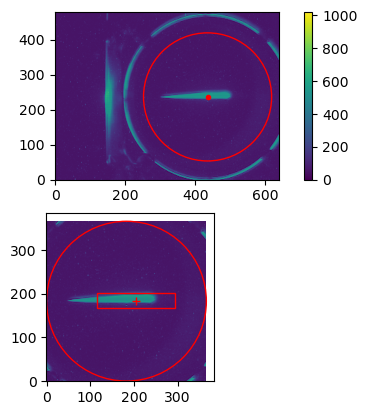

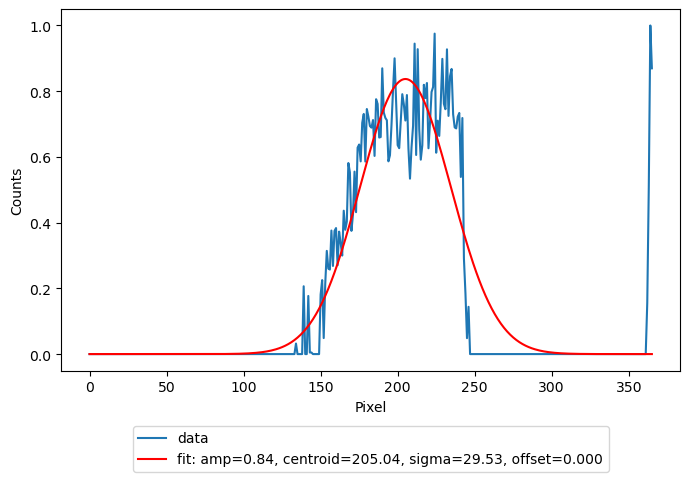

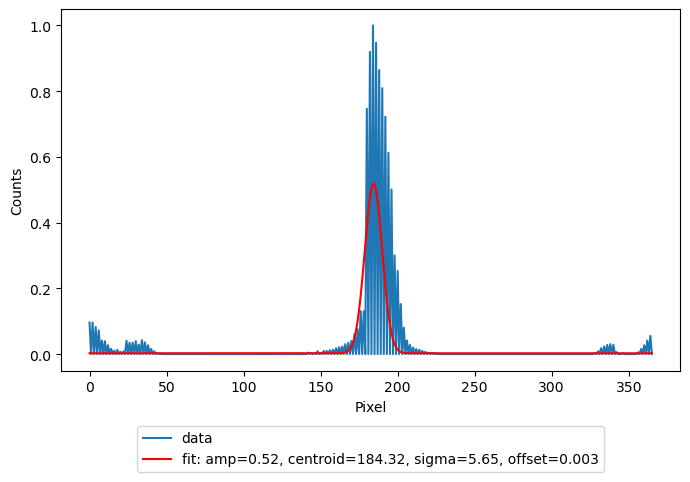

In [2]:
image_diagnostic.test_measurement()

### Define the evaluator

In [3]:
from epics import caput, caget
from xopt import Evaluator
import time
import numpy as np

IMAGE_CONSTRAINTS = {
            "bb_penalty": ["LESS_THAN", 0.0],
            "log10_total_intensity": ["GREATER_THAN", image_diagnostic.min_log_intensity]
        }
image_diagnostic.visualize = False
def evaluate_function(inputs: dict) -> dict:
    global image_diagnostic
    # caput valueslog_transform_acquisition_function
    for name, val in inputs.items():
        caput(name, val)

    # wait for changes to occur - use small wait time for interpolated measurements
    time.sleep(1)

    results = image_diagnostic.measure_beamsize(1, **inputs)

    # add total beam size
    sigma_xy = np.sqrt(np.array(results["Sx"])**2 + np.array(results["Sy"])**2)
    roundness = np.abs(np.array(results["Sx"]) - np.array(results["Sy"]))
    results["total_size"] = sigma_xy + roundness
    print(sigma_xy, roundness, results["total_size"], results["bb_penalty"])
    return results

evaluator = Evaluator(function=evaluate_function)

### Define VOCS
Here we define the names and ranges of input parameters, the names and settings of
objectives, and the names and settings of constraints. Note that the keys here should
 be referenced in the evaluate function above.

In [4]:
from xopt import VOCS

# define control PVs and ranges here
vocs = VOCS(
    variables = {
        #"AWA:Bira3Ctrl:Ch10": [-1, 1], # Quad 4:9
        "AWA:Bira3Ctrl:Ch03": [0,4.0], # 
        "AWA:Bira3Ctrl:Ch04":[-4.0,0], # 
        "AWA:Bira3Ctrl:Ch05":[0,4.0], # 
    },
    objectives = {"total_size":"MINIMIZE"},
    constraints = IMAGE_CONSTRAINTS
)

### Define the Generator

In [5]:
from xopt.generators import get_generator
from xopt.generators.bayesian.models.standard import StandardModelConstructor

model_constructor = StandardModelConstructor(use_low_noise_prior=False)
generator = get_generator("expected_improvement")(
    vocs=vocs, gp_constructor=model_constructor, 
    n_interpolate_points=5, 
    turbo_controller="optimize",
    log_transform_acquisition_function=True,
)
generator.numerical_optimizer.max_time = 10.0
#generator.turbo_controller.failure_tolerance = 6
#generator.turbo_controller.success_tolerance = 6

###  Combine into Xopt object

In [6]:
from xopt import Xopt
import yaml
save_image_location = '.'
dump_filename = save_image_location + "/beamsize_minimization.yml"
X = Xopt(vocs=vocs, generator=generator, evaluator=evaluator, dump_file=dump_filename)

In [7]:
import pandas as pd
#X.add_data(pd.DataFrame(
#    yaml.safe_load(
#        open("beamsize_minimization.yml")
#    )["data"]
#    )
#)

## Introspection
Objects in Xopt can be printed to a string or dumped to a text file for easy
introspection of attributes and current configuration.

In [8]:
# Convenient representation of the state.
X


            Xopt
________________________________
Version: 2.2.1+8.g7a7eff90.dirty
Data size: 0
Config as YAML:
dump_file: ./beamsize_minimization.yml
evaluator:
  function: __main__.evaluate_function
  function_kwargs: {}
  max_workers: 1
  vectorized: false
generator:
  computation_time: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    transform_inputs: true
    use_low_noise_prior: false
  log_transform_acquisition_function: true
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_interpolate_points: 5
  n_monte_carlo_samples: 128
  name: expected_improvement
  numerical_optimizer:
    max_iter: 2000
    max_time: 10.0
    n_restarts: 20
    name: LBFGS
  supports_batch_generation: true
  turbo_controller:
    batch_size: 1
    best_value: null
    center_x: null
    dim: 3
    failure_counter: 0
    failure_tolerance: 2
    length: 0.25
    length_max: 2.0
    length_min: 0.0078

### Initialization

In [9]:
from epics import caget_many
from xopt.utils import get_local_region
import pandas as pd
# 0.684 	1.135 	0.146 0.5
X.evaluate_data(pd.DataFrame([{
    "AWA:Bira3Ctrl:Ch03": 1.14, # 
    "AWA:Bira3Ctrl:Ch04": -2.44, # 
    "AWA:Bira3Ctrl:Ch05": 1.41,
}], columns=X.vocs.variable_names,index=[0]))

# get current point
current_value = dict(zip(X.vocs.variable_names, caget_many(X.vocs.variable_names)))

# get small region around current point to sample
random_sample_region = get_local_region(current_value,X.vocs, fraction=0.05)

random_sample_region

fitting image
35.057670738758596 26.965816013169853 62.023486751928445 -66.6750622396454


{'AWA:Bira3Ctrl:Ch03': [0.94, 1.3399999999999999],
 'AWA:Bira3Ctrl:Ch04': [-2.64, -2.2399999999999998],
 'AWA:Bira3Ctrl:Ch05': [1.21, 1.6099999999999999]}

In [10]:
X.data

,AWA:Bira3Ctrl:Ch03,AWA:Bira3Ctrl:Ch04,AWA:Bira3Ctrl:Ch05,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,total_size,xopt_runtime,xopt_error
0,1.14,-2.44,1.41,193.896913,185.371605,34.285103,7.319287,-66.675062,10298954.0,7.012793,62.023487,2.385386,False


In [11]:
# random sample in a local region
X.random_evaluate(10, custom_bounds=random_sample_region)

fitting image
35.93227217510065 22.050259284603044 57.982531459703694 -70.43673830203183
fitting image
40.801001103336276 14.565039389515007 55.36604049285128 -27.730372422367765
fitting image
34.733365577802026 26.869953077736287 61.60331865553832 -61.62475572316856
fitting image
37.675749984981906 23.152693599787902 60.82844358476981 -63.95293973404118
fitting image
36.770658656797295 23.34326769095901 60.113926347756305 -61.502993844437285
fitting image
44.672690023874516 28.83165672066449 73.504346744539 -39.00365439082543
fitting image
40.161627009596536 14.632424048196224 54.79405105779276 -39.338310323294905
fitting image
51.865999663980844 31.282708074406305 83.14870773838715 -22.403276680560907
fitting image
37.954320842233486 26.489689679318246 64.44401052155173 -55.47727223372664
fitting image
54.080781476104725 27.196188159444592 81.27696963554932 -10.820129725457406


,AWA:Bira3Ctrl:Ch03,AWA:Bira3Ctrl:Ch04,AWA:Bira3Ctrl:Ch05,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,total_size,xopt_runtime,xopt_error
0,0.946209,-2.320261,1.450983,187.968686,182.796547,33.916408,11.866148,-70.436738,11092898.0,7.045045,57.982531,2.783500,False
1,1.188844,-2.622626,1.274108,217.998658,179.010990,35.198926,20.633887,-27.730372,12991279.0,7.113652,55.366040,2.896753,False
2,1.333469,-2.492406,1.242568,199.833033,186.412571,33.994761,7.124808,-61.624756,9950449.0,6.997843,61.603319,2.603731,False
3,1.187582,-2.480542,1.301323,189.191732,183.496616,35.570497,12.417804,-63.952940,11379836.0,7.056136,60.828444,2.423435,False
4,1.279631,-2.573587,1.276963,194.564541,183.530070,34.905524,11.562256,-61.502994,11180231.0,7.048451,60.113926,2.236996,False
5,1.265218,-2.270925,1.374209,174.514830,189.088456,42.522918,13.691262,-39.003654,11418611.0,7.057613,73.504347,2.935100,False
6,1.140752,-2.543246,1.267349,208.077490,180.854875,34.756168,20.123744,-39.338310,12615914.0,7.100919,54.794051,2.212109,False
7,1.166092,-2.300780,1.568447,184.611593,192.632445,48.813466,17.530758,-22.403277,12276992.0,7.089092,83.148708,2.396276,False
8,1.286199,-2.539989,1.267584,196.701255,184.636972,36.586638,10.096949,-55.477272,11276201.0,7.052163,64.444011,2.214514,False
9,1.220067,-2.242938,1.559284,176.720684,192.976304,49.339629,22.143441,-10.820130,12235200.0,7.087611,81.276970,2.351608,False


In [12]:
# examine the data stored in Xopt
X.data

,AWA:Bira3Ctrl:Ch03,AWA:Bira3Ctrl:Ch04,AWA:Bira3Ctrl:Ch05,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,total_size,xopt_runtime,xopt_error
0,1.140000,-2.440000,1.410000,193.896913,185.371605,34.285103,7.319287,-66.675062,10298954.0,7.012793,62.023487,2.385386,False
1,0.946209,-2.320261,1.450983,187.968686,182.796547,33.916408,11.866148,-70.436738,11092898.0,7.045045,57.982531,2.783500,False
2,1.188844,-2.622626,1.274108,217.998658,179.010990,35.198926,20.633887,-27.730372,12991279.0,7.113652,55.366040,2.896753,False
3,1.333469,-2.492406,1.242568,199.833033,186.412571,33.994761,7.124808,-61.624756,9950449.0,6.997843,61.603319,2.603731,False
4,1.187582,-2.480542,1.301323,189.191732,183.496616,35.570497,12.417804,-63.952940,11379836.0,7.056136,60.828444,2.423435,False
5,1.279631,-2.573587,1.276963,194.564541,183.530070,34.905524,11.562256,-61.502994,11180231.0,7.048451,60.113926,2.236996,False
6,1.265218,-2.270925,1.374209,174.514830,189.088456,42.522918,13.691262,-39.003654,11418611.0,7.057613,73.504347,2.935100,False
7,1.140752,-2.543246,1.267349,208.077490,180.854875,34.756168,20.123744,-39.338310,12615914.0,7.100919,54.794051,2.212109,False
8,1.166092,-2.300780,1.568447,184.611593,192.632445,48.813466,17.530758,-22.403277,12276992.0,7.089092,83.148708,2.396276,False
9,1.286199,-2.539989,1.267584,196.701255,184.636972,36.586638,10.096949,-55.477272,11276201.0,7.052163,64.444011,2.214514,False


In [13]:
# run optimization
for i in range(20):
    print(i)
    X.step()

0
fitting image
25.426156212821343 18.879872306397353 44.3060285192187 -93.12084039325676
fitting image
40.71567631107179 13.88589211633925 54.60156842741104 -44.32284313499167
fitting image
nan nan nan 20.87385459710788
fitting image
nan nan nan 132.24554832056378
fitting image
nan nan nan 247.41406450122406
1
fitting image
nan nan nan 216.47951781046726
fitting image
nan nan nan 163.5612212105067
fitting image
nan nan nan 73.40591207276049
fitting image
nan nan nan 32.75887464261703
fitting image
nan nan nan 22.05258285868365
2
fitting image
nan nan nan 20.300666956245863
fitting image
nan nan nan 3.6940717523205535
fitting image
51.367396309310344 2.0956067189117036 53.46300302822205 -2.5435623815826602
fitting image
nan nan nan 17.466182833397255
fitting image
nan nan nan 12.19976050305499
3
fitting image
nan nan nan 11.988109894152416
fitting image
43.96070721744548 8.518289977283434 52.47899719472892 -39.5251473169659
fitting image
42.35213449259505 15.002053824914501 57.35418831

UnboundLocalError: local variable 'result' referenced before assignment

In [ ]:
# visualize result
X.data.plot(y=X.vocs.objective_names[0])

In [ ]:
X.data.plot(y=X.vocs.variable_names)

In [ ]:
image_diagnostic.test_measurement()

In [ ]:
idx, val = X.vocs.select_best(X.data)

In [ ]:
X.evaluate_data(X.data.iloc[idx][X.vocs.variable_names])

In [ ]:
X.data.iloc[idx][X.vocs.variable_names].to_dict(orient="records")

In [ ]:
image_diagnostic.test_measurement()